# Exploring Protein Embeddings

This notebook demonstrates how to load and explore the protein embeddings generated with ESM-C.

Author: Hamed Heydari @ Vevo  
Date: April 01, 2025

In [12]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Set better figure defaults
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('ggplot')

## Define Genes of Interest

We'll focus on some well-known gene families for this exploration.

In [13]:
# Define sets of genes to explore
# Cancer-related genes
CANCER_GENES = ['TP53', 'BRCA1', 'BRCA2', 'EGFR', 'KRAS', 'MYC', 'RB1', 'APC', 'PTEN', 'BRAF']

# Hemoglobin subunits
HEMOGLOBIN_GENES = ['HBA1', 'HBA2', 'HBB', 'HBD', 'HBG1', 'HBG2', 'HBE1', 'HBZ']

# Kinases
KINASE_GENES = ['CDK1', 'CDK2', 'CDK4', 'MAPK1', 'MAPK3', 'MAPK8', 'MAPK14', 'AKT1', 'GSK3B', 'AMPK']

# Combined list for analysis
ALL_GENES_OF_INTEREST = CANCER_GENES + HEMOGLOBIN_GENES + KINASE_GENES

## Load Embeddings from HDF5 File

In [14]:
# Path to the embeddings file
embedding_file = "../output/protein_embeddings_esmc_600m.h5"

# Load the embeddings
with h5py.File(embedding_file, "r") as f:
    # Load metadata
    print("HDF5 file structure:")
    def print_structure(name, obj):
        if isinstance(obj, h5py.Dataset):
            print(f"  {name}: Dataset {obj.shape}, {obj.dtype}")
        elif isinstance(obj, h5py.Group):
            print(f"  {name}: Group")
    
    f.visititems(print_structure)
    
    print("\nFile attributes:")
    for attr_name, attr_value in f.attrs.items():
        print(f"  {attr_name}: {attr_value}")
    
    # Load the embeddings and metadata
    embeddings = f["embeddings"][:]
    uniprot_ids = [id.decode('utf-8') for id in f["uniprot_ids"][:]]
    gene_names = [name.decode('utf-8') if name else "" for name in f["gene_names"][:]]
    
    # Create lookup dictionaries
    gene_to_idx = {gene: idx for idx, gene in enumerate(gene_names) if gene}
    uniprot_to_idx = {uid: idx for idx, uid in enumerate(uniprot_ids)}
    
print(f"Loaded {len(embeddings)} embeddings with dimension {embeddings.shape[1]}")

HDF5 file structure:
  embeddings: Dataset (19329, 1152), float32
  gene_names: Dataset (19329,), |S97
  sequence_lengths: Dataset (19329,), int32
  sequences: Dataset (19329,), |S34350
  uniprot_ids: Dataset (19329,), |S10

File attributes:
  embedding_dimension: 1152
  embedding_model: esmc_600m
  embedding_type: mean_pooled
  flash_attention: disabled
  num_proteins: 19329
  processed_count: 19329
Loaded 19329 embeddings with dimension 1152


## Define Helper Functions

In [15]:
def get_embedding_by_gene(gene_name):
    """Get embedding for a specific gene name."""
    if gene_name in gene_to_idx:
        idx = gene_to_idx[gene_name]
        return embeddings[idx]
    return None

def get_embedding_by_uniprot(uniprot_id):
    """Get embedding for a specific UniProt ID."""
    if uniprot_id in uniprot_to_idx:
        idx = uniprot_to_idx[uniprot_id]
        return embeddings[idx]
    return None

def get_embeddings_for_genes(gene_list):
    """Get embeddings for a list of genes, filtering out those not found."""
    found_genes = []
    found_embeddings = []
    
    for gene in gene_list:
        embedding = get_embedding_by_gene(gene)
        if embedding is not None:
            found_genes.append(gene)
            found_embeddings.append(embedding)
    
    if found_embeddings:
        return np.array(found_embeddings), found_genes
    else:
        return None, []

def plot_similarity_matrix(embeddings_array, labels, title="Cosine Similarity Between Gene Embeddings"):
    """Plot a similarity matrix for the given embeddings."""
    similarity_matrix = cosine_similarity(embeddings_array)
    
    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(
        similarity_matrix,
        xticklabels=labels,
        yticklabels=labels,
        cmap='viridis',
        annot=True if len(labels) < 20 else False,
        annot_kws={"size": 8},
        vmin=0, vmax=1
    )
    plt.title(title, fontsize=14)
    plt.tight_layout()
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    return ax

## Explore Individual Genes

Let's look at a few specific genes to get a feel for the embeddings.

In [16]:
# Check for a few specific genes
example_genes = ['TP53', 'BRCA1', 'HBA1', 'CDK2']

for gene in example_genes:
    embedding = get_embedding_by_gene(gene)
    if embedding is not None:
        print(f"Gene: {gene}")
        print(f"  Embedding shape: {embedding.shape}")
        print(f"  Embedding L2 norm: {np.linalg.norm(embedding):.4f}")
        print(f"  First 5 values: {embedding[:5]}")
        print()
    else:
        print(f"No embedding found for gene {gene}\n")

Gene: TP53
  Embedding shape: (1152,)
  Embedding L2 norm: 0.9401
  First 5 values: [ 0.00223716  0.00369165 -0.01467607 -0.00275215  0.00403628]

Gene: BRCA1
  Embedding shape: (1152,)
  Embedding L2 norm: 1.2569
  First 5 values: [ 0.00227094  0.00097423 -0.00567663  0.02667318  0.01823024]

No embedding found for gene HBA1

Gene: CDK2
  Embedding shape: (1152,)
  Embedding L2 norm: 0.8328
  First 5 values: [ 0.00256635  0.005465   -0.02582025 -0.00376355  0.00672345]



## Analyze Gene Families

Let's compare similarity within and between different gene families.

Found 10/10 cancer genes


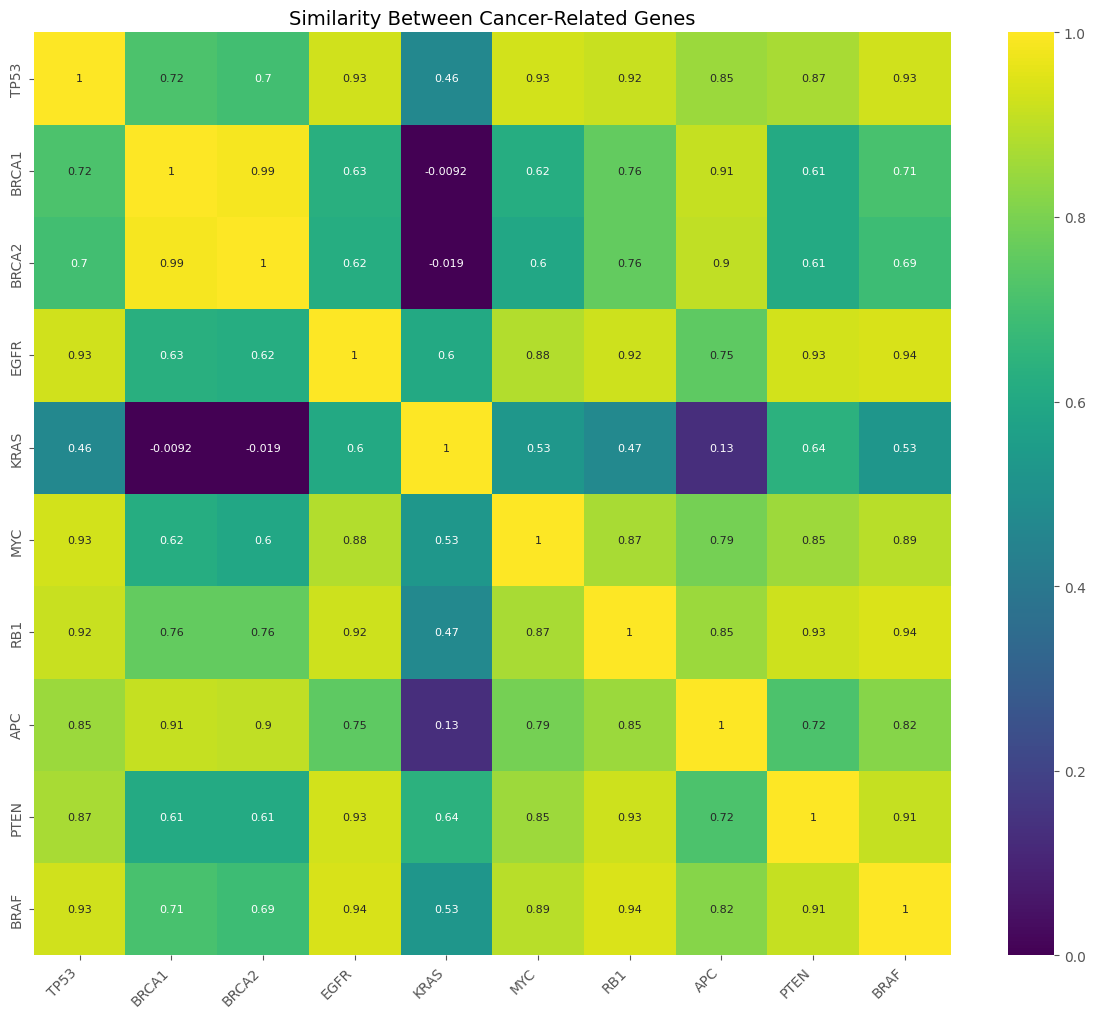

In [17]:
# Get embeddings for cancer genes
cancer_embeddings, found_cancer_genes = get_embeddings_for_genes(CANCER_GENES)

if cancer_embeddings is not None:
    print(f"Found {len(found_cancer_genes)}/{len(CANCER_GENES)} cancer genes")
    plot_similarity_matrix(cancer_embeddings, found_cancer_genes, "Similarity Between Cancer-Related Genes")
else:
    print("No cancer genes found")

Found 6/8 hemoglobin genes


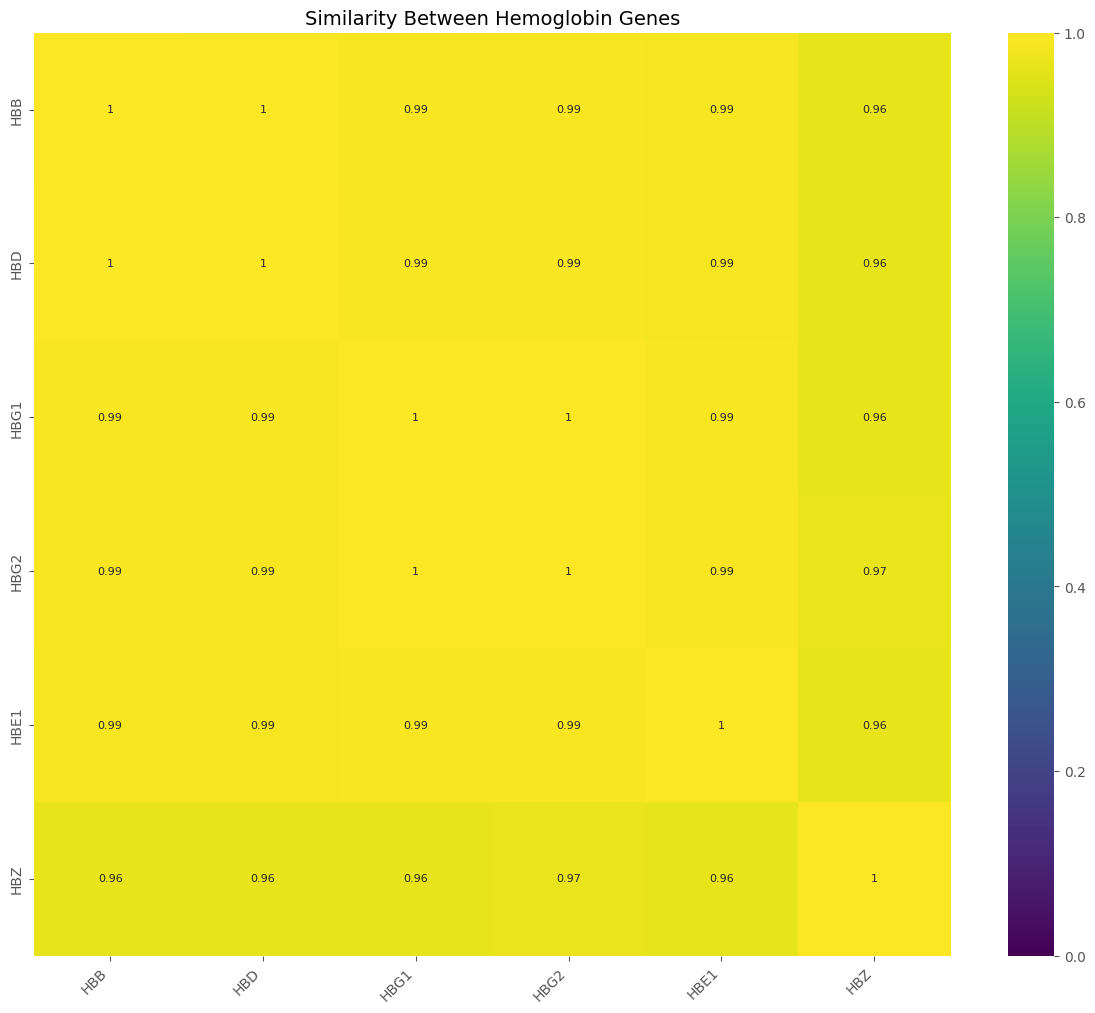

In [18]:
# Get embeddings for hemoglobin genes
hemoglobin_embeddings, found_hemoglobin_genes = get_embeddings_for_genes(HEMOGLOBIN_GENES)

if hemoglobin_embeddings is not None:
    print(f"Found {len(found_hemoglobin_genes)}/{len(HEMOGLOBIN_GENES)} hemoglobin genes")
    plot_similarity_matrix(hemoglobin_embeddings, found_hemoglobin_genes, "Similarity Between Hemoglobin Genes")
else:
    print("No hemoglobin genes found")

Found 9/10 kinase genes


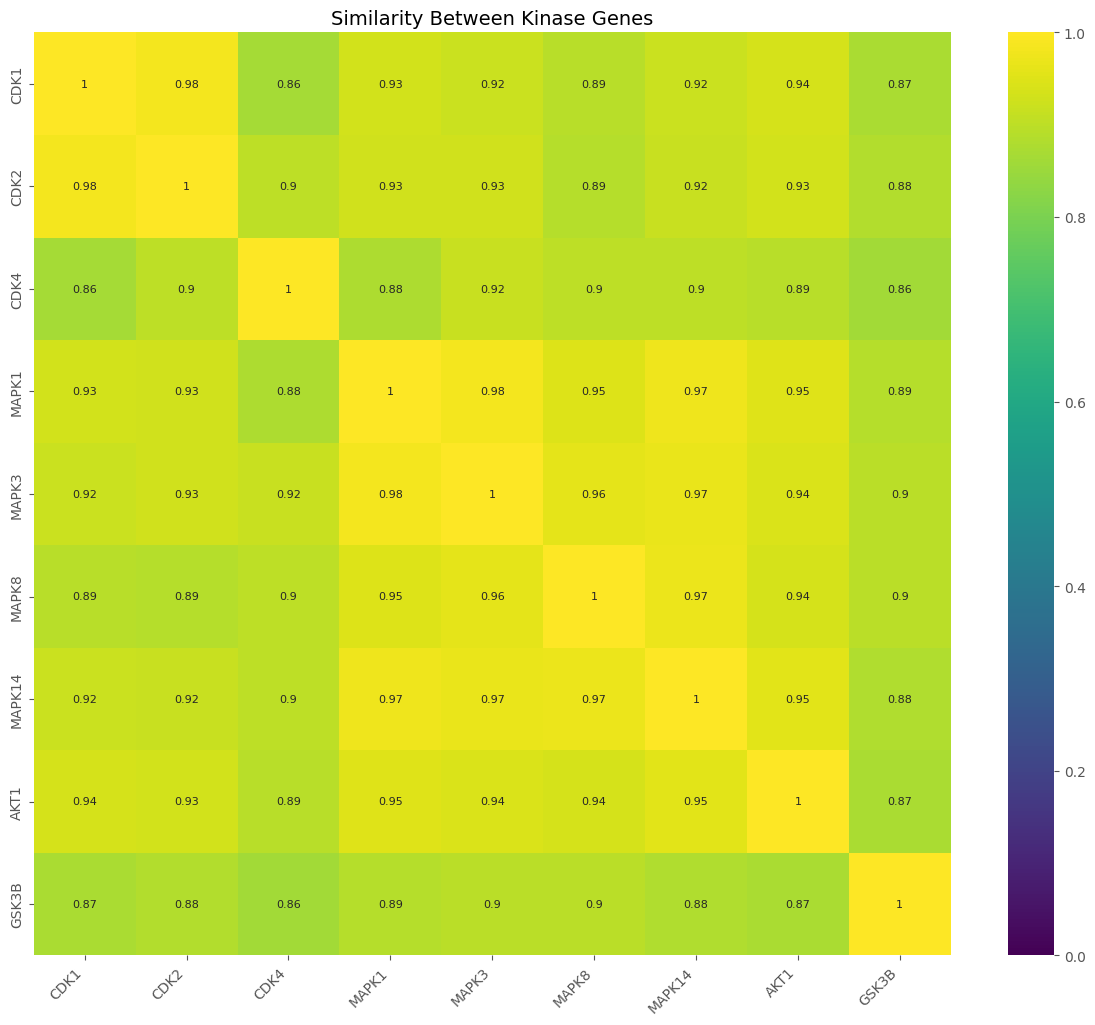

In [19]:
# Get embeddings for kinase genes
kinase_embeddings, found_kinase_genes = get_embeddings_for_genes(KINASE_GENES)

if kinase_embeddings is not None:
    print(f"Found {len(found_kinase_genes)}/{len(KINASE_GENES)} kinase genes")
    plot_similarity_matrix(kinase_embeddings, found_kinase_genes, "Similarity Between Kinase Genes")
else:
    print("No kinase genes found")

## Compare Across Gene Families

Now let's see how the different gene families relate to each other.

Found 25/28 genes total


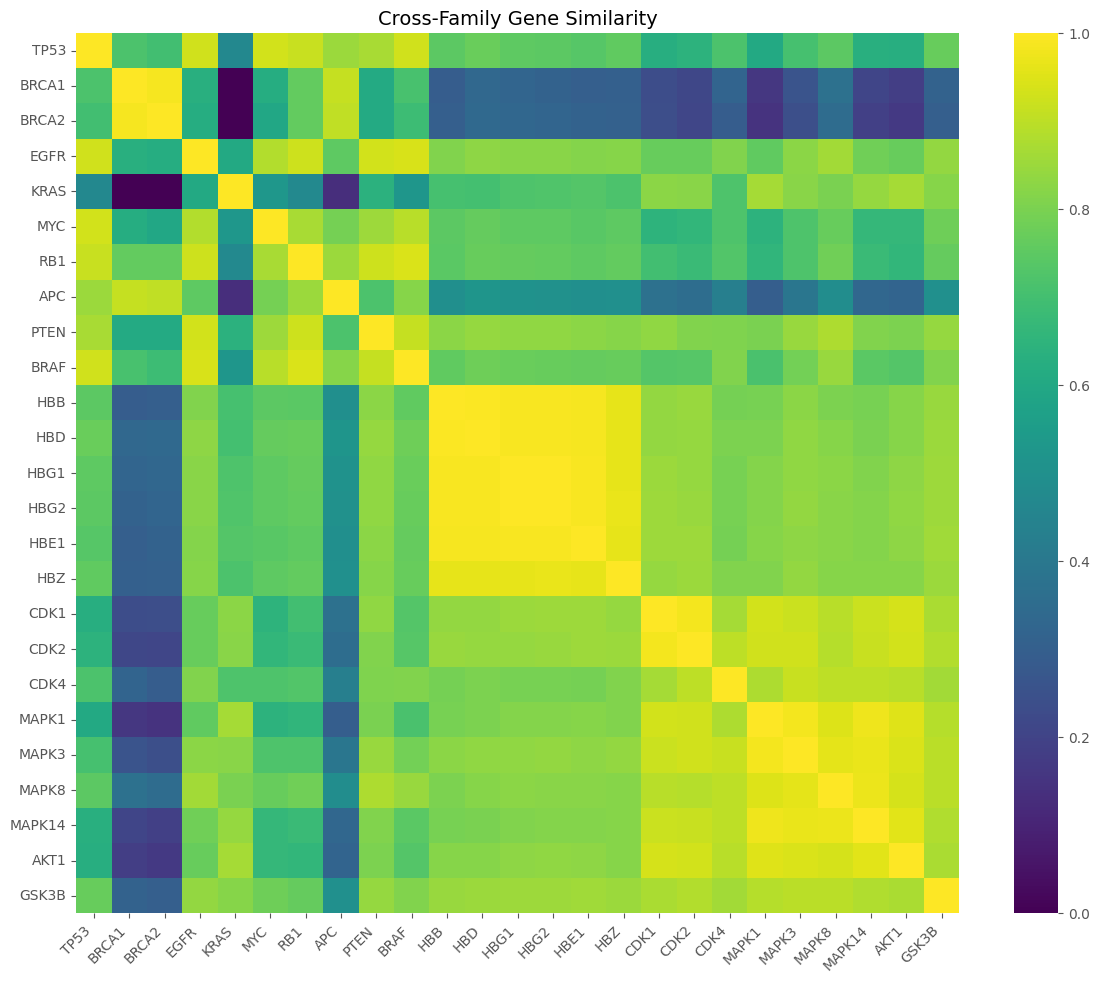

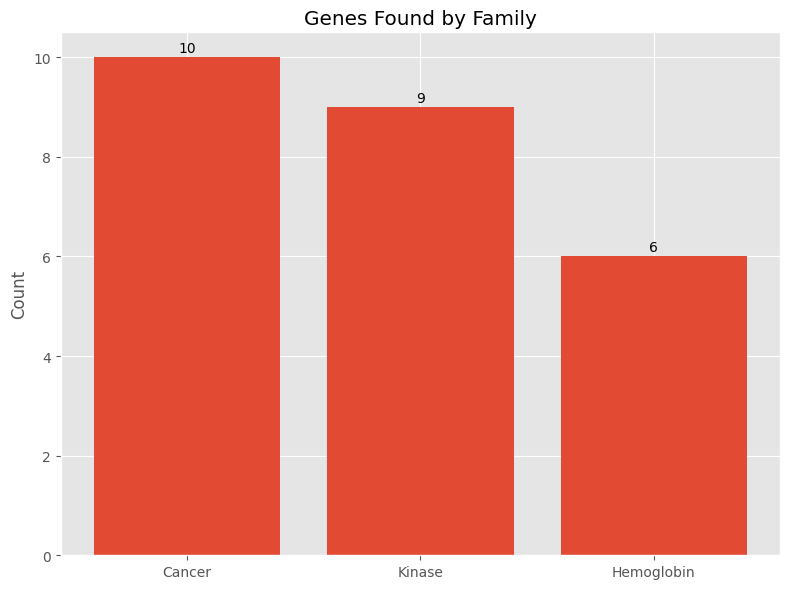

In [20]:
# Combine all gene families
all_embeddings, all_found_genes = get_embeddings_for_genes(ALL_GENES_OF_INTEREST)

if all_embeddings is not None:
    print(f"Found {len(all_found_genes)}/{len(ALL_GENES_OF_INTEREST)} genes total")
    
    # Create a color-coded map to identify gene families
    gene_family = []
    for gene in all_found_genes:
        if gene in CANCER_GENES:
            gene_family.append('Cancer')
        elif gene in HEMOGLOBIN_GENES:
            gene_family.append('Hemoglobin')
        elif gene in KINASE_GENES:
            gene_family.append('Kinase')
        else:
            gene_family.append('Other')
    
    # Plot similarity matrix with gene family annotation
    ax = plot_similarity_matrix(all_embeddings, all_found_genes, "Cross-Family Gene Similarity")
    
    # Add gene family annotations
    plt.figure(figsize=(8, 6))
    gene_family_df = pd.DataFrame({'Gene': all_found_genes, 'Family': gene_family})
    
    # Count genes per family
    family_counts = gene_family_df['Family'].value_counts()
    plt.bar(family_counts.index, family_counts.values)
    plt.title('Genes Found by Family')
    plt.ylabel('Count')
    for i, v in enumerate(family_counts):
        plt.text(i, v + 0.1, str(v), ha='center')
    plt.tight_layout()
else:
    print("No genes found across all families")

## Embedding Statistics

Let's look at some basic statistics of the embeddings.

Embedding statistics:
  Min norm: 0.7983
  Max norm: 1.3760
  Mean norm: 0.9316
  Std dev: 0.1333


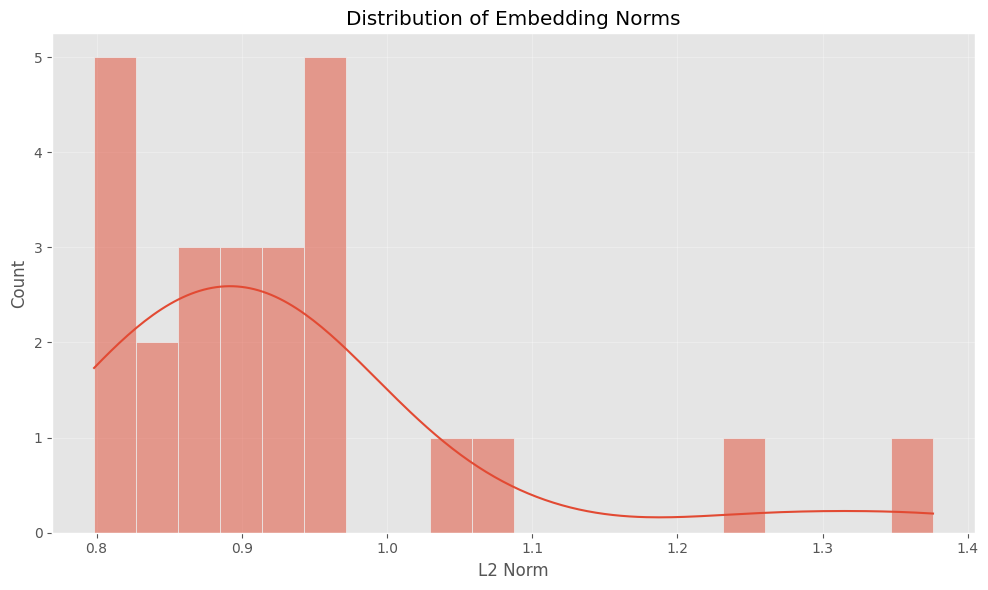

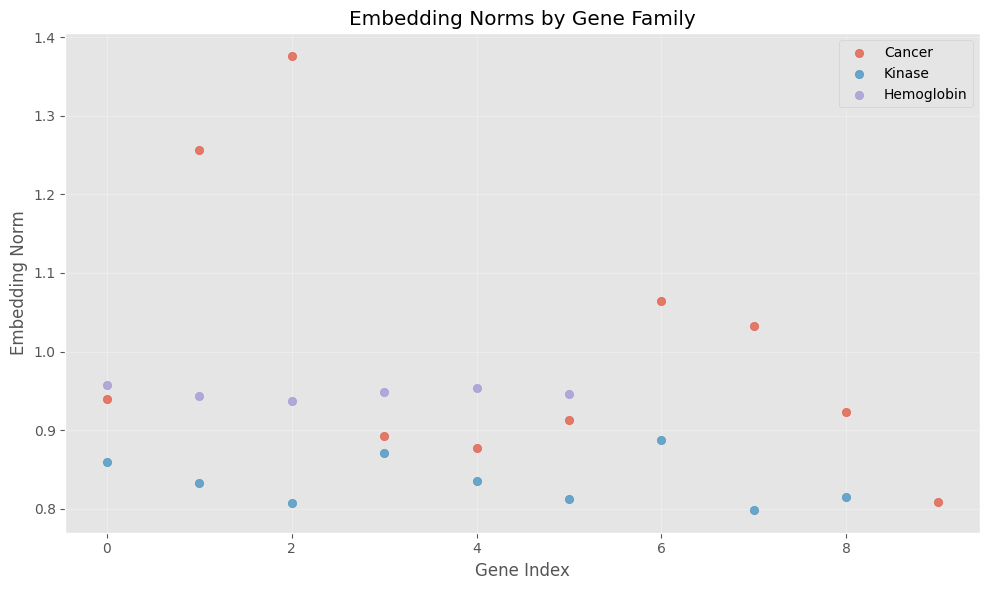

In [21]:
if all_embeddings is not None:
    # Calculate embedding norms
    norms = np.linalg.norm(all_embeddings, axis=1)
    
    # Calculate basic statistics
    print("Embedding statistics:")
    print(f"  Min norm: {norms.min():.4f}")
    print(f"  Max norm: {norms.max():.4f}")
    print(f"  Mean norm: {norms.mean():.4f}")
    print(f"  Std dev: {norms.std():.4f}")
    
    # Plot histogram of norms
    plt.figure(figsize=(10, 6))
    sns.histplot(norms, bins=20, kde=True)
    plt.title('Distribution of Embedding Norms')
    plt.xlabel('L2 Norm')
    plt.ylabel('Count')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Create a scatter plot of norms by gene family
    plt.figure(figsize=(10, 6))
    for family in set(gene_family):
        family_indices = [i for i, f in enumerate(gene_family) if f == family]
        family_norms = norms[family_indices]
        family_genes = [all_found_genes[i] for i in family_indices]
        
        plt.scatter(
            range(len(family_norms)), 
            family_norms, 
            label=family, 
            alpha=0.7
        )
    
    plt.xlabel('Gene Index')
    plt.ylabel('Embedding Norm')
    plt.title('Embedding Norms by Gene Family')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()